
    ID: a unique identifier for each observation
    Date: the date the crime occurred
    LocationDescription: the location where the crime occurred
    Arrest: whether or not an arrest was made for the crime (TRUE if an arrest was made, and FALSE if an arrest was not made)
    Domestic: whether or not the crime was a domestic crime, meaning that it was committed against a family member (TRUE if it was domestic, and FALSE if it was not domestic)
    Beat: the area, or "beat" in which the crime occurred. This is the smallest regional division defined by the Chicago police department.
    District: the police district in which the crime occured. Each district is composed of many beats, and are defined by the Chicago Police Department.
    CommunityArea: the community area in which the crime occurred. Since the 1920s, Chicago has been divided into what are called "community areas", of which there are now 77. The community areas were devised in an attempt to create socially homogeneous regions.
    Year: the year in which the crime occurred.
    Latitude: the latitude of the location at which the crime occurred.
    Longitude: the longitude of the location at which the crime occurred.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("mvtWeek1.csv",parse_dates=['Date'],low_memory=False,index_col='Date')

In [3]:
df

,ID,LocationDescription,Arrest,Domestic,Beat,District,CommunityArea,Year,Latitude,Longitude
Date,,,,,,,,,,
2012-12-31 23:15:00,8951354,STREET,False,False,623,6,69,2012,41.756284,-87.621645
2012-12-31 22:00:00,8951141,STREET,False,False,1213,12,24,2012,41.898788,-87.661303
2012-12-31 22:00:00,8952745,RESIDENTIAL YARD (FRONT/BACK),False,False,1622,16,11,2012,41.969186,-87.767670
2012-12-31 22:00:00,8952223,STREET,False,False,724,7,67,2012,41.769329,-87.657726
2012-12-31 21:30:00,8951608,STREET,False,False,211,2,35,2012,41.837568,-87.621761
...,...,...,...,...,...,...,...,...,...,...
2001-01-01 00:05:00,1310068,STREET,False,False,1123,NaN,NaN,2001,41.887566,-87.711323
2001-01-01 00:01:00,1313404,STREET,False,False,2023,NaN,NaN,2001,41.981924,-87.658878
2001-01-01 00:01:00,1313442,STREET,False,False,911,NaN,NaN,2001,41.799024,-87.696538


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191641 entries, 2012-12-31 23:15:00 to 2001-01-01 00:01:00
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   191641 non-null  int64  
 1   LocationDescription  191641 non-null  object 
 2   Arrest               191641 non-null  bool   
 3   Domestic             191641 non-null  bool   
 4   Beat                 191641 non-null  int64  
 5   District             148589 non-null  object 
 6   CommunityArea        167038 non-null  object 
 7   Year                 191641 non-null  int64  
 8   Latitude             189365 non-null  float64
 9   Longitude            189365 non-null  float64
dtypes: bool(2), float64(2), int64(3), object(3)
memory usage: 13.5+ MB


In [5]:
df.describe()

,ID,Beat,Year,Latitude,Longitude
count,1.916410e+05,191641.000000,191641.000000,189365.000000,189365.000000
mean,4.968629e+06,1258.810771,2006.134940,41.844555,-87.677782
std,2.342997e+06,702.530465,3.520285,0.085583,0.057333
min,1.310022e+06,111.000000,2001.000000,41.644710,-87.925510
25%,2.832144e+06,722.000000,2003.000000,41.771618,-87.718474
50%,4.762956e+06,1121.000000,2006.000000,41.850029,-87.677597
75%,7.201878e+06,1733.000000,2009.000000,41.917116,-87.635513
max,9.181151e+06,2535.000000,2012.000000,42.022878,-87.524676


#### Time series Analysis

In [6]:
pd.date_range(start='2012-12-01',end='2012-12-31')

DatetimeIndex(['2012-12-01', '2012-12-02', '2012-12-03', '2012-12-04',
               '2012-12-05', '2012-12-06', '2012-12-07', '2012-12-08',
               '2012-12-09', '2012-12-10', '2012-12-11', '2012-12-12',
               '2012-12-13', '2012-12-14', '2012-12-15', '2012-12-16',
               '2012-12-17', '2012-12-18', '2012-12-19', '2012-12-20',
               '2012-12-21', '2012-12-22', '2012-12-23', '2012-12-24',
               '2012-12-25', '2012-12-26', '2012-12-27', '2012-12-28',
               '2012-12-29', '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', freq='D')

In [7]:
df.isnull().sum()

ID                         0
LocationDescription        0
Arrest                     0
Domestic                   0
Beat                       0
District               43052
CommunityArea          24603
Year                       0
Latitude                2276
Longitude               2276
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.shape

(191641, 10)

In [10]:
df.dropna(inplace=True)

In [11]:
df.reset_index(drop=True,inplace=True)

In [12]:
df

,ID,LocationDescription,Arrest,Domestic,Beat,District,CommunityArea,Year,Latitude,Longitude
0,8951354,STREET,False,False,623,6,69,2012,41.756284,-87.621645
1,8951141,STREET,False,False,1213,12,24,2012,41.898788,-87.661303
2,8952745,RESIDENTIAL YARD (FRONT/BACK),False,False,1622,16,11,2012,41.969186,-87.767670
3,8952223,STREET,False,False,724,7,67,2012,41.769329,-87.657726
4,8951608,STREET,False,False,211,2,35,2012,41.837568,-87.621761
...,...,...,...,...,...,...,...,...,...,...
148576,1356371,CHA PARKING LOT/GROUNDS,False,False,533,5,54,2001,41.654508,-87.596895
148577,1339061,STREET,False,False,613,6,71,2001,41.745352,-87.654961
148578,1318415,PARKING LOT/GARAGE(NON.RESID.),False,False,1614,16,76,2001,41.981134,-87.841530
148579,1322018,STREET,False,False,1712,17,13,2001,41.975713,-87.713706


### Data Visualization

In [13]:
df['LocationDescription'].value_counts()

STREET                            122567
PARKING LOT/GARAGE(NON.RESID.)     10310
OTHER                               3270
ALLEY                               1688
GAS STATION                         1584
                                   ...  
AIRPORT EXTERIOR - SECURE AREA         1
CURRENCY EXCHANGE                      1
CTA TRAIN                              1
NEWSSTAND                              1
ANIMAL HOSPITAL                        1
Name: LocationDescription, Length: 77, dtype: int64

In [14]:
df['Arrest'].value_counts()

False    137696
True      10885
Name: Arrest, dtype: int64

In [15]:
df['Domestic'].value_counts()

False    148213
True        368
Name: Domestic, dtype: int64

In [16]:
df['Year'].value_counts()

2004    16823
2005    16403
2006    16069
2011    15622
2010    15484
2008    14280
2007    14271
2012    13997
2003    12977
2009    12039
2002      494
2001      122
Name: Year, dtype: int64

In [17]:
df['District'] = pd.to_numeric(df['District'],errors='coerce')

In [18]:
df['District'].isnull().sum()

4

In [19]:
df['CommunityArea'] = pd.to_numeric(df['CommunityArea'],errors='coerce')

In [20]:
df['CommunityArea'].isnull().sum()

12

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148581 entries, 0 to 148580
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   148581 non-null  int64  
 1   LocationDescription  148581 non-null  object 
 2   Arrest               148581 non-null  bool   
 3   Domestic             148581 non-null  bool   
 4   Beat                 148581 non-null  int64  
 5   District             148577 non-null  float64
 6   CommunityArea        148569 non-null  float64
 7   Year                 148581 non-null  int64  
 8   Latitude             148581 non-null  float64
 9   Longitude            148581 non-null  float64
dtypes: bool(2), float64(4), int64(3), object(1)
memory usage: 9.4+ MB


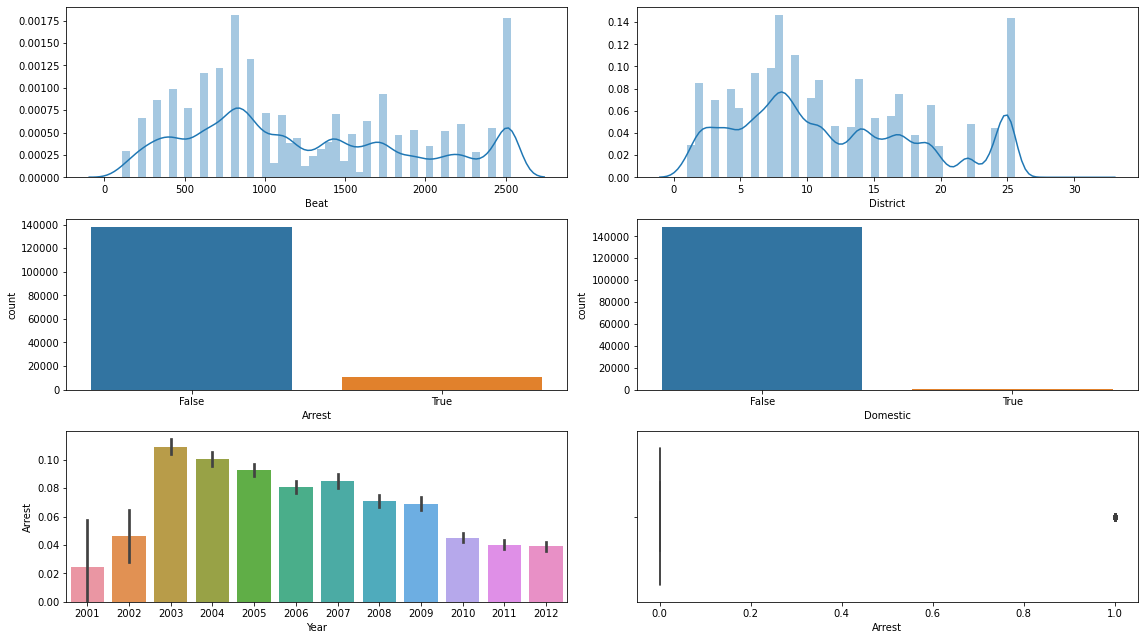

In [22]:
fig = plt.figure(figsize=(16,9))

plt.subplot(3,2,1)
sns.distplot(df.Beat)
plt.subplot(3,2,2)
sns.distplot(df.District)
plt.subplot(3,2,3)
sns.countplot(x=df['Arrest'])
plt.subplot(3,2,4)
sns.countplot(x=df['Domestic'])
plt.subplot(3,2,5)
sns.barplot(x=df['Year'],y=df['Arrest'])
plt.subplot(3,2,6)
sns.boxplot(x=df['Arrest'])
plt.tight_layout()
plt.show()

In [23]:
df.isnull().sum()

ID                      0
LocationDescription     0
Arrest                  0
Domestic                0
Beat                    0
District                4
CommunityArea          12
Year                    0
Latitude                0
Longitude               0
dtype: int64

In [24]:
df.dropna(inplace=True)

In [25]:
df.reset_index(drop=True,inplace=True)

In [26]:
df

,ID,LocationDescription,Arrest,Domestic,Beat,District,CommunityArea,Year,Latitude,Longitude
0,8951354,STREET,False,False,623,6.0,69.0,2012,41.756284,-87.621645
1,8951141,STREET,False,False,1213,12.0,24.0,2012,41.898788,-87.661303
2,8952745,RESIDENTIAL YARD (FRONT/BACK),False,False,1622,16.0,11.0,2012,41.969186,-87.767670
3,8952223,STREET,False,False,724,7.0,67.0,2012,41.769329,-87.657726
4,8951608,STREET,False,False,211,2.0,35.0,2012,41.837568,-87.621761
...,...,...,...,...,...,...,...,...,...,...
148560,1356371,CHA PARKING LOT/GROUNDS,False,False,533,5.0,54.0,2001,41.654508,-87.596895
148561,1339061,STREET,False,False,613,6.0,71.0,2001,41.745352,-87.654961
148562,1318415,PARKING LOT/GARAGE(NON.RESID.),False,False,1614,16.0,76.0,2001,41.981134,-87.841530
148563,1322018,STREET,False,False,1712,17.0,13.0,2001,41.975713,-87.713706


### Data Preprocessing

In [27]:
# Target label is ARREST

In [28]:
df2 = df[['Domestic','Beat','District','CommunityArea', 'Arrest']]

In [29]:
df2

,Domestic,Beat,District,CommunityArea,Arrest
0,False,623,6.0,69.0,False
1,False,1213,12.0,24.0,False
2,False,1622,16.0,11.0,False
3,False,724,7.0,67.0,False
4,False,211,2.0,35.0,False
...,...,...,...,...,...
148560,False,533,5.0,54.0,False
148561,False,613,6.0,71.0,False
148562,False,1614,16.0,76.0,False
148563,False,1712,17.0,13.0,False


In [30]:
encoder = LabelEncoder()

In [31]:
df2['Arrest'] = encoder.fit_transform(df2['Arrest'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
df2

,Domestic,Beat,District,CommunityArea,Arrest
0,False,623,6.0,69.0,0
1,False,1213,12.0,24.0,0
2,False,1622,16.0,11.0,0
3,False,724,7.0,67.0,0
4,False,211,2.0,35.0,0
...,...,...,...,...,...
148560,False,533,5.0,54.0,0
148561,False,613,6.0,71.0,0
148562,False,1614,16.0,76.0,0
148563,False,1712,17.0,13.0,0


In [33]:
df2['Arrest'].value_counts()

0    137682
1     10883
Name: Arrest, dtype: int64

In [34]:
df2['Domestic'].value_counts()

False    148197
True        368
Name: Domestic, dtype: int64

In [35]:
df3 = pd.get_dummies(df2,columns=['Domestic'],drop_first=True)

In [36]:
df3

,Beat,District,CommunityArea,Arrest,Domestic_True
0,623,6.0,69.0,0,0
1,1213,12.0,24.0,0,0
2,1622,16.0,11.0,0,0
3,724,7.0,67.0,0,0
4,211,2.0,35.0,0,0
...,...,...,...,...,...
148560,533,5.0,54.0,0,0
148561,613,6.0,71.0,0,0
148562,1614,16.0,76.0,0,0
148563,1712,17.0,13.0,0,0


In [38]:
df4 = df3[['Beat','District','CommunityArea','Domestic_True','Arrest']]

In [39]:
df4

,Beat,District,CommunityArea,Domestic_True,Arrest
0,623,6.0,69.0,0,0
1,1213,12.0,24.0,0,0
2,1622,16.0,11.0,0,0
3,724,7.0,67.0,0,0
4,211,2.0,35.0,0,0
...,...,...,...,...,...
148560,533,5.0,54.0,0,0
148561,613,6.0,71.0,0,0
148562,1614,16.0,76.0,0,0
148563,1712,17.0,13.0,0,0


### Model Training

In [41]:
X = df4.iloc[:,0:4]
y = df4.iloc[:,4]

In [42]:
X.values, y.values

(array([[ 623.,    6.,   69.,    0.],
        [1213.,   12.,   24.,    0.],
        [1622.,   16.,   11.,    0.],
        ...,
        [1614.,   16.,   76.,    0.],
        [1712.,   17.,   13.,    0.],
        [ 831.,    8.,   66.,    0.]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [43]:
scalar = StandardScaler()

In [44]:
X_scaled = scalar.fit_transform(X)

In [45]:
X_scaled

array([[-0.90255769, -0.83529972,  1.44911542, -0.04983153],
       [-0.06072167,  0.02616509, -0.65169775, -0.04983153],
       [ 0.52285618,  0.60047496, -1.25859934, -0.04983153],
       ...,
       [ 0.51144146,  0.60047496,  1.77590859, -0.04983153],
       [ 0.65127185,  0.74405243, -1.16522986, -0.04983153],
       [-0.60577482, -0.54814479,  1.30906121, -0.04983153]])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [47]:
X_train.shape, X_test.shape

((118852, 4), (29713, 4))

In [49]:
xgb = XGBClassifier(random_state=0, n_estimators=400, objective='binary:logistic')

In [51]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='auc',early_stopping_rounds=20)

[0]	validation_0-auc:0.536436
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.549721
[2]	validation_0-auc:0.549206
[3]	validation_0-auc:0.549769
[4]	validation_0-auc:0.549874
[5]	validation_0-auc:0.549874
[6]	validation_0-auc:0.549716
[7]	validation_0-auc:0.549963
[8]	validation_0-auc:0.549805
[9]	validation_0-auc:0.549781
[10]	validation_0-auc:0.54964
[11]	validation_0-auc:0.552728
[12]	validation_0-auc:0.552951
[13]	validation_0-auc:0.552897
[14]	validation_0-auc:0.552942
[15]	validation_0-auc:0.554787
[16]	validation_0-auc:0.554741
[17]	validation_0-auc:0.555113
[18]	validation_0-auc:0.557367
[19]	validation_0-auc:0.557369
[20]	validation_0-auc:0.557471
[21]	validation_0-auc:0.557068
[22]	validation_0-auc:0.557012
[23]	validation_0-auc:0.557133
[24]	validation_0-auc:0.557537
[25]	validation_0-auc:0.558511
[26]	validation_0-auc:0.557776
[27]	validation_0-auc:0.558297
[28]	validation_0-auc:0.558598
[29]	validation_0-auc:0.558621
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:
y_pred = xgb.predict(X_test)

In [53]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Model Evaluation

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     27556
           1       0.00      0.00      0.00      2157

    accuracy                           0.93     29713
   macro avg       0.46      0.50      0.48     29713
weighted avg       0.86      0.93      0.89     29713



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


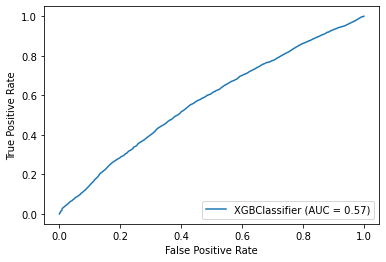

In [55]:
plot_roc_curve(xgb,X_test,y_test)